In [37]:

from simulator.reporters import TransitionReporter
from simulator.core import Task
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from simulator import Config

In [38]:
def loadDataframe(reportMapPath: str) -> pd.DataFrame:
    reportMap = None
    with open("reportMaps/" + reportMapPath, "r") as reportFile:
        reportMap = json.load(reportFile)
    
    # Finding all config changes
    configList = set()
    for report in reportMap:
        varients = report["varient"]
        for varient in varients:
            configList.add(varient["config"])
            
    tupleTemplate = {}
    for config in configList:
        tupleTemplate[config] = Config.get(config)
        tupleTemplate[config + "_default"] = True
    print(tupleTemplate)
    
    tupleList = []
    for report in reportMap:
        reportTupleTemplate = tupleTemplate.copy()
        runId = report["runId"]
        varients = report["varient"]
        for varient in varients:
            config = varient["config"]
            reportTupleTemplate[config] = varient["value"]
            reportTupleTemplate[config + "_default"] = False
        
        mobileReport = TransitionReporter.getListFromPickle("reports/reportmobile" + runId + ".pkl")
        for item in mobileReport:
            tuple = reportTupleTemplate.copy()
            tuple["task_id"] = item.task.id()
            tuple["arrival_time"] = item.task.arrivalTime()
            tuple["delay"] = item.delay
            tuple["power"] = item.powerConsumtion
            tuple["action"] = item.action
            tuple["hopLimit"] = item.task.hopLimit()
            tupleList.append(tuple)
            
    df = pd.DataFrame(tupleList)
    # unify action values
    df["action"] = df["action"].apply(lambda x: 0 if ("0" in str(x)) else (1 if ("1" in str(x)) else x))
    
    return df

In [39]:
df = loadDataframe("reportMap2.json")

{'mode_tasks_from_task_list': False, 'mode_tasks_from_task_list_default': True, 'task_generation_duration': 100, 'task_generation_duration_default': True, 'mobile_selector': 'dql', 'mobile_selector_default': True, 'edge_selector': 'dql', 'edge_selector_default': True, 'mode_workload_provided': True, 'mode_workload_provided_default': True, 'dql_learning_discount': 0.8, 'dql_learning_discount_default': True, 'boxworld_mobile_nodes': 50, 'boxworld_mobile_nodes_default': True}


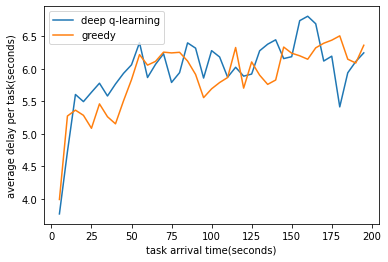

In [40]:
vairable_conditions = {
    "deep q-learning": (df["mobile_selector"] == "dql") & (df["edge_selector"] == "dql"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy")
}
condition =  (df["mode_workload_provided"] == False) & (df["mode_tasks_from_task_list"] == True)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = df.loc[item_condition, ["delay"]].groupby(
        pd.cut(df["arrival_time"], np.arange(0, 200, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data)

plt.ylabel('average delay per task(seconds)')
plt.xlabel('task arrival time(seconds)')
plt.legend(graphs.keys(), loc='upper left')